# Principal Component Analysis (PCA) and Empirical Orthogonal Functions (EOFs)

The goal of *principal component analysis (PCA)* is to efficiently represent variability that is common among multiple variables. One application is to create an "index" that describes how different variables co-vary, or how a single variable co-varies in different places. *Empirical orthogonal functions (EOFs)* are a very similar type of analysis that involves the same basic steps (often seen in Physical Oceanography or Meteorology literature).

## Visualizing in two dimensions (two variables)

PCA is easiest to visualize when there are only two variables. The same data can be visualized on different axes if you simply rotate the data into a new coordinate system with new axes. 

![images/PCA_1.png](images/PCA_1.png)

*Image source*: Joliffe (1990), Principal Component Analysis: A Beginner's Guide — I. Introduction and application, *Weather* https://rmets.onlinelibrary.wiley.com/doi/10.1002/j.1477-8696.1990.tb05558.x

In the figure above, the data are rotated into a new coordinate system that maximizes the variance, or spread, in the data along the horizontal $z_1$-axis (the major axis) and minimizes the variance along the vertical $z_2$-axis (the minor axis). This particular type of PCA in two dimensions is often referred to as principal axis analysis. This analysis, which is described in detail below, creates a new coordinate frame that maximizes variability along an axis (PC1) and corresponding orthogonal axis (PC2) where PC1 and PC2 are uncorrelated.
    
A common application of this type of analysis is to rotate data from a East/North coordinate system to *natural coordinates* primary oriented with the coastline or topography.

#### Example - Wind vectors

![images/PCA_2.png](images/PCA_2.png)

Source: Patrick Daniel, MLML

## Principal component analysis: steps
1. Create data matrix (size: N x M, N rows and M columns)
   - standardize if necessary (if data is a combination of different variables)
2. Form the covariance matrix (M x M)
3. Extract eigenvalues and eigenvectors from covariance matrix
4. The eigenvectors are the principal components, the eigenvalues are their magnitudes

Here these steps are decribed for a two dimensional example, focusing on the wind buoy example above.

#### 1. Data matrix, __X__

Creating a data matrix, $X$

N rows, M columns

$$\begin{bmatrix} u_1 & v_1 
\\ u_2 & v_2 
\\ u_3 & v_3
\\ \vdots & \vdots
\\ u_N & v_N \end{bmatrix}$$
                
N - number of concurrent samples 

M - number of variables

For the wind example, $u$ is eastward velocity and $v$ is northward velocity.

3.6622712082782454 1.107372677049764


(4000.0, 5999.0)

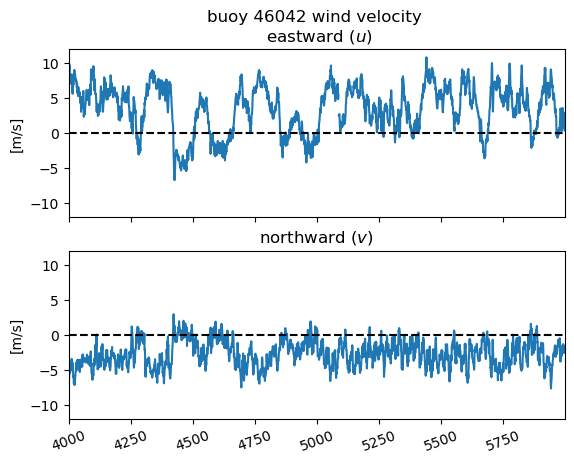

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

file_path_csv = 'data/ndbc_wind_pca/buoyData_5_years.csv'
data = pd.read_csv(file_path_csv)

def princax(u,v=None):
    '''
Principal axes of a vector time series.
Usage:
theta,major,minor = princax(u,v) # if u and v are real-valued vector components
    or
theta,major,minor = princax(w)   # if w is a complex vector
Input:
u,v - 1-D arrays of vector components (e.g. u = eastward velocity, v = northward velocity)
    or
w - 1-D array of complex vectors (u + 1j*v)
Output:
theta - angle of major axis (math notation, e.g. east = 0, north = 90)
major - standard deviation along major axis
minor - standard deviation along minor axis
Reference: Emery and Thomson, 2001, Data Analysis Methods in Physical Oceanography, 2nd ed., pp. 325-328.
Matlab function: http://woodshole.er.usgs.gov/operations/sea-mat/RPSstuff-html/princax.html
    '''

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

def rot(u,v,theta):
    """
Rotate a vector counter-clockwise OR rotate the coordinate system clockwise.
Usage:
ur,vr = rot(u,v,theta)
Input:
u,v - vector components (e.g. u = eastward velocity, v = northward velocity)
theta - rotation angle (degrees)
Output:
ur,vr - rotated vector components
Example:
rot(1,0,90) returns (0,1)
    """

    w = u + 1j*v             # complex vector
    ang = theta*np.pi/180    # convert angle to radians
    wr = w*np.exp(1j*ang)    # complex vector rotation
    ur = np.real(wr)         # return u and v components
    vr = np.imag(wr)
    return ur,vr

idx = np.arange(4000,6000)
tlim = [np.min(data.index[idx]), np.max(data.index[idx])]

u = data.u
v = data.v
theta,major,minor = princax(u[idx],v[idx])
print(major, minor)
data['u_rotated'], data['v_rotated'] = rot(u,v,abs(theta))

plt.figure()
plt.subplot(211)
plt.plot(data.index[idx],data.u[idx])
plt.xticks(visible=False)
plt.ylim([-12,12])
plt.title('buoy 46042 wind velocity \n eastward ($u$)')
plt.ylabel('[m/s]')
plt.plot(tlim, [0, 0], 'k--')
plt.xlim(tlim)

plt.subplot(212)
plt.plot(data.index[idx],data.v[idx])
plt.xticks(rotation=20)
plt.title('northward ($v$)')
plt.ylim([-12, 12])
plt.ylabel('[m/s]')
plt.plot(tlim, [0, 0], 'k--')
plt.xlim(tlim)

We could also plot these $u$ and $v$ components as a scatter plot.

Text(0, 0.5, 'northward $v$ [m/s]')

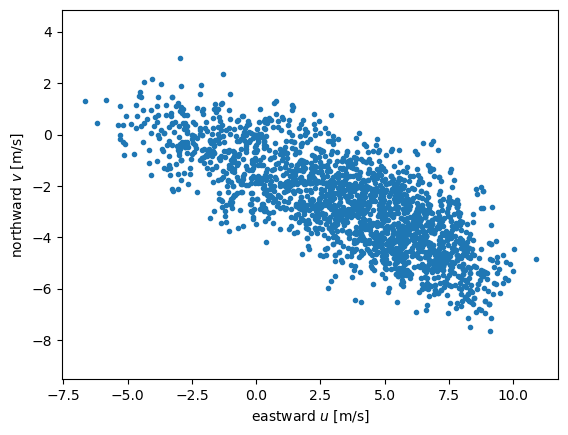

In [3]:
plt.figure()
plt.plot(data.u[idx], data.v[idx], '.')
plt.plot()
plt.gca().axis('equal');
plt.xlabel('eastward $u$ [m/s]')
plt.ylabel('northward $v$ [m/s]')

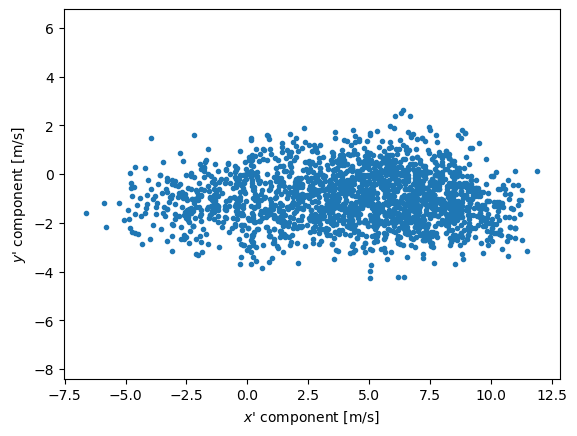

In [4]:
plt.figure()
plt.plot(data.u_rotated[idx], data.v_rotated[idx], '.')
plt.gca().axis('equal');
plt.xlabel('$x$\' component [m/s]')
plt.ylabel('$y$\' component [m/s]')
plt.savefig('wind-uv-rotated-scatter.png')

In [13]:
u = np.array(data.u)
v = np.array(data.v)
u_rotated = np.array(data.u_rotated)
v_rotated = np.array(data.v_rotated)

gi, = np.where(np.isfinite(u[idx] + v[idx]))
stats.linregress(u[idx][gi], v[idx][gi])
np.cov(u[idx][gi], v[idx][gi])
np.cov(u_rotated[idx][gi], v_rotated[idx][gi]);

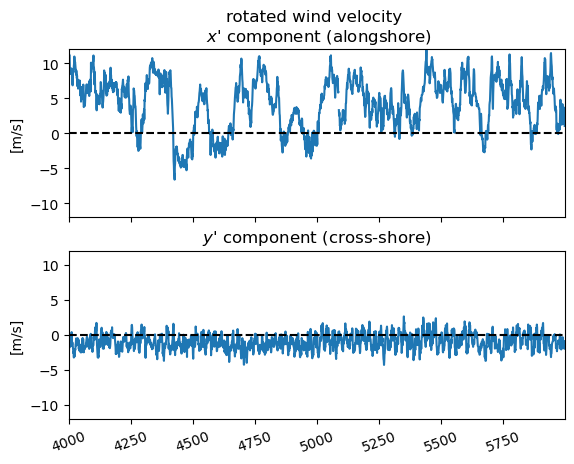

In [14]:
plt.figure()
plt.subplot(211)
plt.plot(data.index[idx],data.u_rotated[idx])
plt.xticks(visible=False)
plt.ylim([-12,12])
plt.title('rotated wind velocity \n $x$\' component (alongshore)')
plt.ylabel('[m/s]')
plt.plot(tlim, [0, 0], 'k--')
plt.xlim(tlim)

plt.subplot(212)
plt.plot(data.index[idx],data.v_rotated[idx])
plt.xticks(rotation=20)
plt.title('$y$\' component (cross-shore)')
plt.ylim([-12,12])
plt.ylabel('[m/s]')
plt.plot(tlim, [0, 0], 'k--')
plt.xlim(tlim)
plt.savefig('wind-uv-rotated')

#### 2. Covariance matrix, C  (or correlation matrix, R)

The covariance matrix __C__ has  M rows and M columns (M x M). It contains the covariance between all possible combinations of the M different variables that are stored in the different columns of __X__.
    
$$\begin{bmatrix}
c_{11} & c_{12} & c_{13} & \cdots & c_{1M}\\
c_{21} & c_{22} & c_{23} & \cdots & c_{2M}\\
c_{31} & c_{32} & c_{33} & \cdots & c_{3M}\\
\vdots & \vdots & \vdots & \ddots &       \\
c_{M1} & c_{M2} & c_{M3} &        & c_{MM}\\
\end{bmatrix}$$
        
Alternatively, the correlation matrix, __R__, can also be used. Recall that the correlation between two variables is the covariance scaled by the standard deviation of the variables, $r_{uv} = \frac{c_{uv}}{s_u s_v}$. 
   
$$\begin{bmatrix}
1      & r_{12} & r_{13} & \cdots & r_{1M}\\
r_{21} & 1      & r_{23} & \cdots & r_{2M}\\
r_{31} & r_{32} & 1      & \cdots & r_{3M}\\
\vdots & \vdots & \vdots & \ddots &       \\
r_{M1} & r_{M2} & r_{M3} &        & 1     \\
\end{bmatrix}$$

The diagonal elements of the correlation matrix are all equal to 1. 

The covariance matrix is generally used when all variables have the same units. Variables or locations with greater variance are weighted higher. The correlation matrix is used when the variables have different units, or if the overall magnitudes do not matter. Use of the correlation matrix standardizes the data so that they are all weighted equally. It is equivalent to transforming the data into z-scores first, and then computing the covariance matrix.
   
##### Current meter example: covariance matrix 

For the case of finding the principal component of wind or current meter data, the variables are the eastward component ($u$) and the northward component ($v$). The covariance matrix has two rows and two columns.

$$\begin{bmatrix}
c_{uu} & c_{uv}\\
c_{vu} & c_{vv}\\
\end{bmatrix}$$

$c_{uu}$  variance of $u$ <br>

$c_{vv}$  variance of $v$<br>

$c_{uv}$  covariance of $u$ and $v$ <br>

The values for this wind example are,

$$\begin{bmatrix}
11.3 & -4.61\\
-4.61 & 3.33\\
\end{bmatrix}$$

where the units are in $\text{m}^2/\text{s}^2$.

Calculating the covariance matrix can also be done in Python with the numpy.cov() function. 

#### 3. Extracting the eigenvalues and eigenvectors from the covariance matrix

The eigenvectors (contained in the matrix $V$) and eigenvalues (contained in the matrix $\Lambda$) of the $C$ matrix are defined by the relationship:

$$CV =  V \Lambda$$

$V$ =  eigenvectors (M x M matrix)

$$\begin{bmatrix}
v_{11} & v_{12} & v_{13} & \cdots\\
v_{21} & v_{22} & v_{23} & \cdots\\
v_{31} & v_{32} & v_{33} & \cdots\\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}$$

Each column is one eigenvector

$\Lambda$ = eigenvalues (M x M)

$$\begin{bmatrix}
\lambda_{1} & 0 & 0 & \cdots \\
0 & \lambda_{2} & 0 & \cdots \\
0 & 0 & \lambda_{3} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}$$

where $\lambda _1$ - eigenvalue # 1, $\lambda _2$ - eigenvalue # 2, etc.

#### 4. Physical meaning of the eigenvalues and eigenvectors

The *eigenvectors* describe directions in M-dimensional space. These are called the principal components, which define the orientation of new axes for the data. All eigenvectors are orthogonal (or perpendicular, for the 2D case). The vectors that define the axes can be scaled any magnitude, but usually they are scaled to have a value of one (unit vectors).

The *eigenvalues* describe how each eigenvector is scaled. They describe the variance in the data along each axis defined by the orientations of the eigenvectors.

#### Back to the current meter example

To compute the eigenvectors and eigenvalues of a matrix in Python, use:
```python
from scipy import linalg
linalg.eig(C)
```
<br>

For the covariance matrix $C$ given above for the wind data,

$$V = \begin{bmatrix}
0.91 & 0.42\\
-0.42 & 0.91
\end{bmatrix}$$

The columns of the V matrix define the orientation of the new axes (or principal components) in $u, v$ space. The first column defining PC 1 has a negative slope ($u$ = 0.91, $v$ = -0.42) because the variance in the data is primarily oriented in the northwest/southeast axis in $u,v$ space.

$$\Lambda = \begin{bmatrix}
13.4 & 0\\
0 & 1.23
\end{bmatrix}$$


$\lambda _1$ = 13.4 $\frac{m^2}{s^2}$ = variance along PC 1 <br>
$\lambda _2$ = 1.23 $\frac{m^2}{s^2}$ = variance along PC 2  <br>

Note that there is much more variance along PC 1 (the major axis) than PC 2 (the minor axis). The data have been rotated so that the variance is maximized along PC 1 and minimized along PC 2.

To recover the data in the rotated coordinates,

$\tau _1 = X V_i$

$\tau _1$ = u(0.91) + v(-0.42) <br>
$\tau _2$ = u(0.42) + v(0.91)

For this example, this would create new variables for alongshore and cross-shore velocity. This is the same data, just rotated into a new set of axes, where alongshore is defined by the axis of maximum variance (the major axis).

Factor loading is another common terminology encountered in EOFs, and refers to the larger spread of data in the first eigenvector (original example v') than in the second (u')and thereby quantifying their relative importance and are defined by:

$A =  V \sqrt{\Lambda}$

Factor loading can be visualized as the length of a PC vector, whereby PC1 would have a longer vector compared to PC2. 

The figure below shows the factor loadings for the wind data. The PCs are scaled so that the length of the PC1 vector is the standard deviation of of the data along that axis ($\sqrt{13.4} = 3.7$ m/s) and the length of the PC2 vector is the standard deviation of of the data along that axis ($\sqrt{1.23} = 1.1$ m/s)

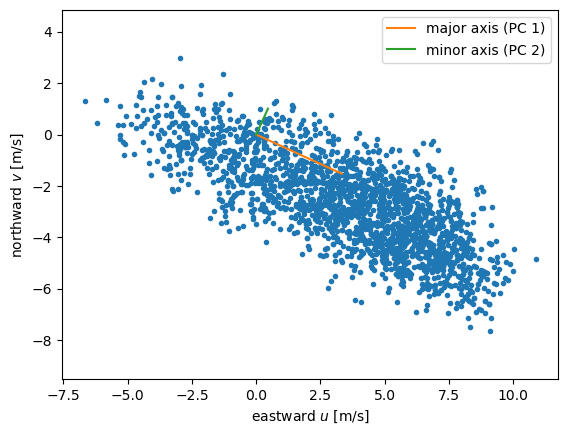

In [25]:
plt.figure()
plt.plot(data.u[idx], data.v[idx], '.')
plt.plot([0, major*np.cos(theta*np.pi/180)], 
         [0, major*np.sin(theta*np.pi/180)], label='major axis (PC 1)')
plt.plot([0, minor*np.cos(theta*np.pi/180 + np.pi/2)], 
         [0, minor*np.sin(theta*np.pi/180 + np.pi/2)], label='minor axis (PC 2)')
plt.gca().axis('equal');
plt.xlabel('eastward $u$ [m/s]')
plt.ylabel('northward $v$ [m/s]')
plt.legend();

## 3-D visualization of principal components

For three variables, defined by three axes, three principal components are obtained. The first two PCs define a plane in three-dimensional space. These are the two axes that define a a plane where the data would be most spread out if you looked at the data from a perspective perpendicular to the plane.

For an interactive visualization of PCA in three dimensions, see this link:

http://setosa.io/ev/principal-component-analysis/

## Example: the Pacific Decadal Oscillation

![images/PCA_PDO.png](images/PCA_PDO.png)

[source](http://research.jisao.washington.edu/pdo/)

The Pacific Decadal Oscillation (PDO) is defined as the first principal component of SST in the North Pacific. The origin of this index comes from Davis (1976).

This study used binned SST data from 1947-1974 in 82 different sites across the Pacific Ocean.

![images/PCA_PDO_Bins.png](images/PCA_PDO_Bins.png)

Davis, R.E. (1976) Predictability of sea surface temperature and sea level pressure anomalies over the North Pacific Ocean. _J. Phys. Oceanogr._, 6, 249-266.

![images/PCA_PDO_STD.png](images/PCA_PDO_STD.png)

Standard deviation of temperature anomaly [deg C] 

Temperature anomaly = temperature – seasonal monthly mean temperature

#### Data matrix:

(336 X 82) -> 28 years * 12 month
    
#### Create a covariance matrix (what size?) 

(82 x 82)
    
#### First principal component/empirical orthogonal function of North Pacific SST

![images/PCA_PDO_First.png](images/PCA_PDO_First.png)

This is the dominant "mode" of temperature variability in the North Pacific, based on how temperature at different locations co-vary together (i.e. the covariance matrix). 

This PC is a vector defined by 82 different numbers. It is the first column of an (82 x 82) eigenvector matrix (V). It can be visualized by mapping each value back to its corresponding spatial location.

#### Other principal components of North Pacific SST

![images/PCA_PDO_All.png](images/PCA_PDO_All.png)

Fraction of Variance that is accounted for by the fist M empirical orthogonal functions:

![images/PCA_PDO_Var.png](images/PCA_PDO_Var.png)

#### Principal component scores

The first PC can be used to create an index describing the time variability of the dominant mode. This is the PDO index, which decribes a mode of temperature variability that can be compared with ecosystem parameters (e.g. zooplankton abundance).

![images/PCA_PDO_Index.png](images/PCA_PDO_Index.png)


##### PCA assumptions
- Relationships between variables are linear
- Mean and variance are sufficient statistics (variables have Gaussian/normal distribution)
- Large variances have import dynamics (high signal to noise ration)
- The principal components are orthogonal

##### PCA Issues

- Does not take into account phase lags between correlated variables, can detect "standing" features but not propagating waves. The PDO oscillates back and forth between cool and warm phases like a see-saw, it does not propagate across the Pacific like a wave. If there are wave-like features in the data, PCA will split up the variance between multiple modes, confusing interpration.

- Domain dependence: can get a different answer by changing the spatial extent of the data

Shlens, J., A tutorial on principal component analysis: Derivation, discussion and singular value decomposition.  https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf 

Example:
![images/PCA_Issue.png](images/PCA_Issue.png)

If no dominant pattern exists, PCA will pick out a pattern that may not be robust.